#### Dependencies


In [ ]:
import time
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, DataCollatorWithPadding,
    BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_config, get_peft_model, IA3Config
import evaluate
import matplotlib.pyplot as plt
import pandas as pd


c:\Python311\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [ ]:
from peft import (
    prepare_model_for_kbit_training,
    get_peft_model,
    LoraConfig,
    TaskType,
)

In [3]:

imdbDS = load_dataset('imdb')
trainRaw = imdbDS['train'].shuffle(seed=42).select(range(3000))
testRaw = imdbDS['test'].shuffle(seed=42).select(range(2000))


In [8]:
testRaw

Dataset({
    features: ['text', 'label'],
    num_rows: 2000
})

In [10]:
testRaw.shape

(2000, 2)

In [7]:
testRaw.features['label']

ClassLabel(names=['neg', 'pos'], id=None)

In [4]:
tokenizer = AutoTokenizer.from_pretrained('roberta-base')


## Part 1: Data Preprocessing 


In [5]:

def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=256)


In [6]:
trainDataset = trainRaw.map(tokenize, batched=True)


In [7]:
trainDataset

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 3000
})

In [8]:
testDataset = testRaw.map(tokenize, batched=True)
testDataset

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 2000
})

In [9]:
dataCollator = DataCollatorWithPadding(tokenizer)


In [10]:

trainDataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
testDataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])


## Part 2: Model Implementation 

In [13]:
accuracy = evaluate.load('accuracy')
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    return accuracy.compute(predictions=preds, references=labels)

### Method 1: Full Fine-Tuning 

In [11]:
model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
args_full = TrainingArguments(
    output_dir="m1output",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    save_strategy="no",
    logging_steps=50,
    report_to=["none"],            
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:

start = time.time()
trainer_full = Trainer(
    model=model, args=args_full,
    train_dataset=trainDataset, eval_dataset=testDataset,
    tokenizer=tokenizer, data_collator=dataCollator,
    compute_metrics=compute_metrics
)
trainer_full.train()
end = time.time()

C:\Users\Javeria Shahid\AppData\Local\Temp\ipykernel_30828\2421353682.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_full = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.408500,0.342942,0.891500
2,0.328600,0.300406,0.901500
3,0.151900,0.476262,0.908000


In [20]:
model_output_dir = "./fft"  
trainer_full.save_model(model_output_dir)  
tokenizer.save_pretrained(model_output_dir)  

('./fft\\tokenizer_config.json',
 './fft\\special_tokens_map.json',
 './fft\\vocab.json',
 './fft\\merges.txt',
 './fft\\added_tokens.json',
 './fft\\tokenizer.json')

In [ ]:
model_full = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=2).cuda()
args_full = TrainingArguments(
    output_dir="m1output",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    save_strategy="no",
    logging_steps=50,
    report_to=["none"],            
)

torch.cuda.reset_peak_memory_stats()
start = time.time()
trainer_full = Trainer(
    model=model_full, args=args_full,
    train_dataset=trainDataset, eval_dataset=testDataset,
    tokenizer=tokenizer, data_collator=dataCollator,
    compute_metrics=compute_metrics
)
trainer_full.train()
end = time.time()
metrics_full = trainer_full.evaluate()
metrics_full['trainable_params'] = sum(p.numel() for p in model_full.parameters() if p.requires_grad)
metrics_full['train_time'] = end - start
metrics_full['max_gpu_mem'] = torch.cuda.max_memory_allocated() / (1024**3)


### Method 2: LoRA Fine-Tuning Using PEFT

In [ ]:
peft_config = LoraConfig(
    task_type='SEQ_CLS', inference_mode=False,
    r=16, lora_alpha=32, lora_dropout=0.1
)

In [ ]:

model_lora = get_peft_model(
    AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=2).cuda(),
    peft_config
)

In [ ]:

args_lora = TrainingArguments(
    'lora_output', eval_strategy='epoch', num_train_epochs=3,
    per_device_train_batch_size=8, per_device_eval_batch_size=8,
    save_strategy='no', logging_steps=50, report_to=["none"]
)

In [ ]:
torch.cuda.reset_peak_memory_stats()

In [ ]:


start = time.time()
trainer_lora = Trainer(
    model=model_lora, args=args_lora,
    train_dataset=trainDataset, eval_dataset=testDataset,
    tokenizer=tokenizer, data_collator=dataCollator,
    compute_metrics=compute_metrics
)
trainer_lora.train()
end = time.time()
metrics_lora = trainer_lora.evaluate()
metrics_lora['trainable_params'] = sum(p.numel() for p in model_lora.parameters() if p.requires_grad)
metrics_lora['train_time'] = end - start
metrics_lora['max_gpu_mem'] = torch.cuda.max_memory_allocated() / (1024**3)


### Method 3: QLoRA Fine-Tuning 

In [18]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

In [15]:
import torch.nn as nn

In [16]:
if hasattr(model.classifier, 'out_proj'):
    orig = getattr(model.classifier, 'out_proj')
    W = orig.weight.data.detach().clone().float()
    b = orig.bias.data.detach().clone().float()
    new = nn.Linear(W.size(1), W.size(0))
    new.weight.data.copy_(W)
    new.bias.data.copy_(b)
    setattr(model.classifier, 'out_proj', new)


In [ ]:




model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)
model = prepare_model_for_kbit_training(model)

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["query", "key", "value"],
    bias="none",
)
model = get_peft_model(model, peft_config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


training_args = TrainingArguments(
    output_dir="qlora_output",
    eval_strategy="epoch",
    save_strategy="no",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_steps=50,
    report_to=["none"],
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=trainDataset,
    eval_dataset=testDataset,
    tokenizer=tokenizer,
    data_collator=dataCollator,
    compute_metrics=compute_metrics,
)


torch.cuda.reset_peak_memory_stats()
start = time.time()
trainer.train()
end = time.time()

metrics_qlora = trainer.evaluate()
metrics_qlora["trainable_params"] = sum(p.numel() for p in model.parameters() if p.requires_grad)
metrics_qlora["train_time_sec"] = end - start
metrics_qlora["max_gpu_mem_GB"] = torch.cuda.max_memory_allocated() / 1024**3



### Method 4: Adapter Tuning (IA3) 

In [ ]:
ia3_config = IA3Config(
    task_type='SEQ_CLS', inference_mode=False
)
model_ia3 = get_peft_model(
    AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=2).cuda(),
    ia3_config
)
args_ia3 = TrainingArguments(
    'ia3_output', eval_strategy='epoch', num_train_epochs=3,
    per_device_train_batch_size=8, per_device_eval_batch_size=8,
    save_strategy='no', logging_steps=50, report_to=["none"]
)
torch.cuda.reset_peak_memory_stats()
start = time.time()
trainer_ia3 = Trainer(
    model=model_ia3, args=args_ia3,
    train_dataset=trainDataset, eval_dataset=testDataset,
    tokenizer=tokenizer, data_collator=dataCollator,
    compute_metrics=compute_metrics
)
trainer_ia3.train()
end = time.time()
metrics_ia3 = trainer_ia3.evaluate()
metrics_ia3['trainable_params'] = sum(p.numel() for p in model_ia3.parameters() if p.requires_grad)
metrics_ia3['train_time'] = end - start
metrics_ia3['max_gpu_mem'] = torch.cuda.max_memory_allocated() / (1024**3)


## Part 3: Evaluation Metrics 


In [ ]:
results = {
    'Full': metrics_full,
    'LoRA': metrics_lora,
    'QLoRA': metrics_qlora,
    'IA3': metrics_ia3
}
df = pd.DataFrame([{**{'Method':k}, **{ 'accuracy':v['eval_accuracy'], 'trainable_params':v['trainable_params'], 'train_time':v['train_time'], 'gpu_mem_GB':v['max_gpu_mem']}} for k,v in results.items()])
df

,Method,accuracy,trainable_params,train_time,gpu_mem_GB
0,Full,0.9140,124647170,614.141521,2.638919
1,LoRA,0.9115,1181954,459.041533,1.481977
2,QLoRA,0.9045,1034498,670.509710,1.355802
3,IA3,0.8495,656642,474.443455,2.854391


## Part 4: Visualization 



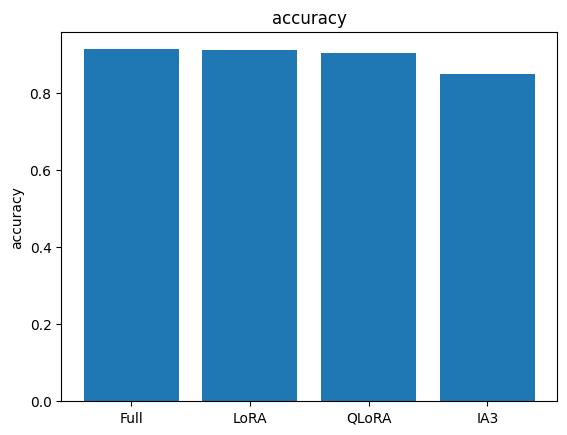

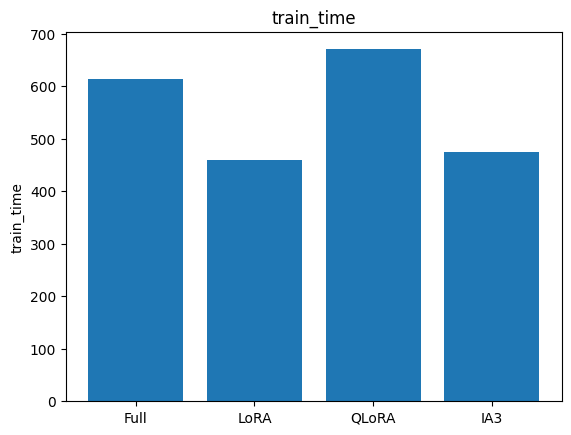

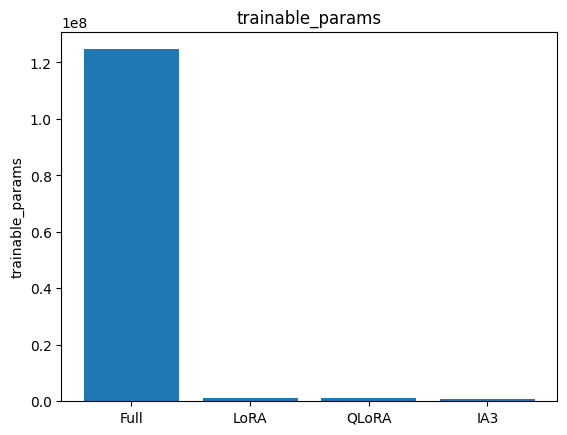

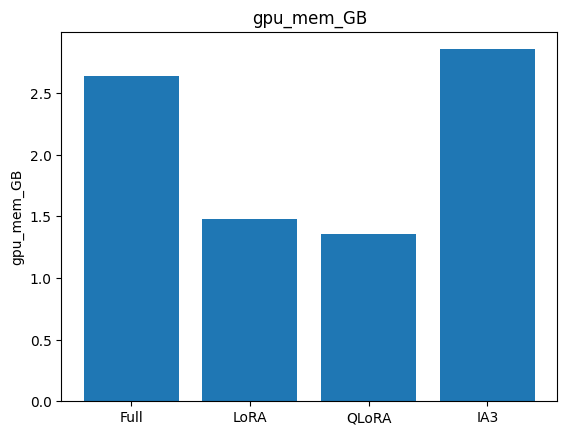

In [18]:
metrics = ['accuracy','train_time','trainable_params','gpu_mem_GB']
for m in metrics:
    plt.figure()
    plt.bar(df['Method'], df[m])
    plt.title(m)
    plt.ylabel(m)
    plt.show()